In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# import 
import os
import numpy as np
import pandas as pd
import seaborn as sns
from fitter import Fitter, get_common_distributions, get_distributions
import matplotlib.pyplot as plt
from uncertainty_motion_prediction.dataloader import Dataloader
from uncertainty_motion_prediction.evaluators import DistanceErrorEvaluator
from uncertainty_motion_prediction.predictor import (
    HMMMultinomialFirstOrder, HMMLatentSegmentsExtractor, KMeansOutcome, HMMLatentSegmentsPredictor
)
from uncertainty_motion_prediction.predictor import HMMContinuousEmissionsPredictor
from hmmlearn import hmm

from uncertainty_motion_prediction.visualizer import SamplingVisualizer, visualize_covariance_to_axis


In [3]:
#from uncertainty_motion_prediction.predictor.hmm_continuous_emissions import normalise_segment_batch
from uncertainty_motion_prediction.predictor import normalise_segment_batch


# Load the Dataset and Overview of the Data

Load and Data and conduct some brief analysis on the pattern of the normalised segment.

In [4]:
#Switch the dataset
'''
0: eth-univ
1: eth-hotel
2: ucy-zara1
3: ucy-zara2
4: ucy-univ3
'''
dataset_no = 0

In [5]:
dataset=Dataloader();
traj_dataset = dataset.load(dataset_no)

In [6]:
segment_length = 4
num_segment = 4# Hidden Markov Model with Gaussian emissions (to model trajectory observations)

#Start by instantiating a HMM with continuous Gaussian emission distributions.
trajlets_for_hmm_learning = traj_dataset.get_trajlets(
    length =num_segment * segment_length*0.4, overlap=4, to_numpy=True
)
print(trajlets_for_hmm_learning.shape)

(666, 16, 5)


In [7]:
trajlets_shape = trajlets_for_hmm_learning.shape
normalised = normalise_segment_batch(trajlets_for_hmm_learning[:, :, 0:4], segment_length)
sequence_lengths = np.array([num_segment for i in range(trajlets_shape[0])])



In [8]:
#take a look at the data
df = pd.DataFrame(normalised)
df.describe()

,0,1,2,3,4,5,6,7
count,2664.0,2664.000000,2664.000000,2664.000000,2664.0,2664.000000,2664.000000,2664.000000
mean,0.0,0.306846,0.605178,0.902981,0.0,-0.000332,-0.000128,0.000785
std,0.0,0.063128,0.119934,0.177591,0.0,0.027845,0.061351,0.095630
min,0.0,-0.032546,-0.312057,-0.430313,0.0,-0.169395,-0.330768,-0.463417
25%,0.0,0.297757,0.602622,0.905960,0.0,-0.013083,-0.033656,-0.050771
50%,0.0,0.321502,0.642359,0.960801,0.0,0.000000,0.000000,0.000000
75%,0.0,0.336688,0.660541,0.982692,0.0,0.012146,0.033746,0.052287
max,0.0,0.462775,0.739210,0.999846,0.0,0.158536,0.252680,0.435744


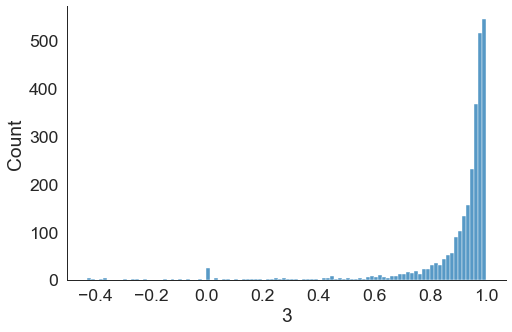

In [9]:
sns.set_style('white')
sns.set_context("paper", font_scale = 2)
sns.displot(data=df, x=3, kind="hist", bins = 100, aspect = 1.5)


In [10]:
# Pair-wise Scatter Plots
# pp = sns.pairplot(df, size=1.8, aspect=1.8,
#                   plot_kws=dict(edgecolor="k", linewidth=0.5),
#                   diag_kind="kde", diag_kws=dict(shade=True))

# fig = pp.fig 
# fig.subplots_adjust(top=0.93, wspace=0.3)
# t = fig.suptitle('Wine Attributes Pairwise Plots', fontsize=14)


# Hidden Markov Model with Gaussian emissions (to model trajectory observations)

Start by instantiating a HMM with continuous Gaussian emission distributions.

In [11]:
if dataset_no == 0:
    # ETC Uni
    n_components = 10
    covariance_type = "full"
    n_iter = 50
elif dataset_no == 1:
    # ETC Hotel
    n_components = 4
    covariance_type = "full"
    n_iter = 50
elif dataset_no == 2:
    # ETC Hotel
    n_components = 4
    covariance_type = "full"
    n_iter = 50
elif dataset_no == 3:
    # ETC Hotel
    n_components = 4
    covariance_type = "full"
    n_iter = 50
elif dataset_no == 4:
    # ucy-univ3
    n_components = 10
    covariance_type = "full"
    n_iter = 80
elif dataset_no == 5:
    # ucy-univ3
    n_components = 4
    covariance_type = "full"
    n_iter = 80


model = hmm.GaussianHMM(n_components=n_components, covariance_type=covariance_type, 
                        init_params='stmc', n_iter=n_iter, verbose=True)

Preprocess the trajectories by normalising them (without the adjustment on Rotation). Then we estimate the model parameters (transition matrix and Gaussian emission distribution parameters).

In [12]:
var_param = 1
covar = np.array ([[1, 0., 0., 0., 0., 0., 0., 0.],
                  [0., 1, 1, 1, 0., 0., 0., 0.],
                   [0., 1, 1, 1, 0., 0., 0., 0.],
                   [0., 1, 1, 1, 0., 0., 0., 0.],
                    [0., 0, 0, 0, 1, 0., 0., 0.],
                    [0., 0, 0, 0, 0, 1, 1, 1],
                    [0., 0, 0, 0, 0, 1, 1, 1],
                    [0., 0, 0, 0, 0, 1, 1, 1]])



covars = var_param* np.tile(covar, (n_components, 1, 1))


In [13]:
#model.covars_ = covars

In [14]:
trajlets_shape = trajlets_for_hmm_learning.shape
normalised = normalise_segment_batch(trajlets_for_hmm_learning[:, :, 0:4], segment_length)
sequence_lengths = np.array([num_segment for i in range(trajlets_shape[0])])

model.fit(normalised[:,np.r_[1:4,5:8]], lengths=sequence_lengths)

         1       22497.3871             +nan
         2       29084.7511       +6587.3639
         3       30544.2585       +1459.5074
         4       31400.7087        +856.4503
         5       31815.7095        +415.0008
         6       31975.2005        +159.4910
         7       32065.8418         +90.6413
         8       32146.4940         +80.6522
         9       32194.5650         +48.0711
        10       32230.0301         +35.4651
        11       32260.5252         +30.4951
        12       32327.1582         +66.6330
        13       32374.3803         +47.2221
        14       32412.9516         +38.5713
        15       32467.3172         +54.3656
        16       32993.3833        +526.0662
        17       32627.6752        -365.7082


GaussianHMM(covariance_type='full', n_components=10, n_iter=50, verbose=True)

In [15]:
model.covars_

array([[[ 2.78021552e-04,  1.77881124e-04,  4.65783944e-05,
          5.67811315e-05,  1.32098378e-04,  1.28697957e-04],
        [ 1.77881124e-04,  2.70692928e-04,  6.84875167e-05,
          8.12022021e-05,  1.77028715e-04,  1.88965850e-04],
        [ 4.65783944e-05,  6.84875167e-05,  1.14770246e-04,
          4.80733717e-05,  1.74753371e-04,  2.51635317e-04],
        [ 5.67811315e-05,  8.12022021e-05,  4.80733717e-05,
          3.01660542e-04,  2.98451932e-04,  3.51049874e-04],
        [ 1.32098378e-04,  1.77028715e-04,  1.74753371e-04,
          2.98451932e-04,  7.61052792e-04,  9.85164844e-04],
        [ 1.28697957e-04,  1.88965850e-04,  2.51635317e-04,
          3.51049874e-04,  9.85164844e-04,  1.94530712e-03]],

       [[ 8.42438303e-04,  5.53776654e-04,  1.60861183e-03,
          5.56731048e-04,  8.42795480e-04,  9.87502616e-04],
        [ 5.53776654e-04,  1.83994622e-02,  1.25762546e-02,
          1.18901216e-03,  2.17183376e-03,  4.03161220e-03],
        [ 1.60861183e-03,  1.2

In [16]:
import pickle
with open('gaussian_hmm_%s.pkl'%dataset_no, 'wb') as file:
    pickle.dump(model, file)


In [17]:
model.transmat_

array([[2.18104961e-001, 3.07077031e-252, 1.87917071e-001,
        6.14241962e-003, 1.08224035e-003, 1.83657447e-002,
        5.19179690e-001, 2.61391619e-003, 0.00000000e+000,
        4.65939562e-002],
       [8.32453188e-025, 8.31994999e-002, 9.14980673e-016,
        3.67787370e-030, 1.85034468e-001, 3.16284235e-032,
        9.60783871e-057, 3.20024945e-001, 3.29558656e-001,
        8.21824302e-002],
       [2.69909847e-001, 1.17546070e-114, 9.94015649e-002,
        1.17312690e-001, 1.74558409e-002, 8.11337706e-002,
        1.63453682e-001, 2.18787145e-002, 1.98175457e-070,
        2.29453890e-001],
       [1.73609731e-001, 3.94370634e-106, 9.73536947e-002,
        2.72612495e-001, 1.67889136e-002, 1.93417217e-001,
        4.37752593e-002, 4.90508035e-002, 6.08643600e-060,
        1.53391887e-001],
       [9.60571113e-012, 4.55942164e-002, 8.39913036e-002,
        7.46180167e-009, 6.00545907e-001, 7.24992155e-002,
        1.02186165e-017, 3.67597749e-002, 1.44380450e-001,
        1.6

## Deploy Trained Model

Set up to test the model.

In [18]:
import pickle

model = None
with open('gaussian_hmm_%s.pkl'%dataset_no, 'rb') as file:
    model = pickle.load(file)


In [19]:
segment_length = 4
num_segment = 4
num_history_segment = 2
num_future_segment = num_segment - num_history_segment
predictor = HMMContinuousEmissionsPredictor(hmm = model,N_future_segment=num_future_segment)

In [20]:
traj_length = num_segment * (segment_length - 1) + 1
history_traj_length = num_history_segment * (segment_length - 1) + 1
future_traj_length = num_future_segment * (segment_length - 1) + 1

trajlets_for_testing = traj_dataset.get_trajlets(
    length=traj_length * 0.4 ,
    overlap=1,
    to_numpy=True
)
print(trajlets_for_testing.shape)


(518, 13, 5)


In [21]:
traj = trajlets_for_testing[10]
print(traj[:, 0:2])
predicted = predictor.predict(traj[0:history_traj_length, :])
print(predicted)

[[-2.58775    -0.4150006 ]
 [-2.2562569   0.1774096 ]
 [-1.674122    0.52848254]
 [-1.3844306   0.72587986]
 [-0.70869114  1.0702393 ]
 [-0.35812648  1.4518583 ]
 [ 0.28415438  1.5985637 ]
 [ 0.82029767  1.8346148 ]
 [ 1.2401766   1.9750675 ]
 [ 1.7626818   2.2054314 ]
 [ 2.4753376   2.4322782 ]
 [ 2.9287631   2.6110303 ]
 [ 3.6670676   2.8302069 ]]
[[0.28415438 1.5985637 ]
 [0.9574425  1.74856647]
 [1.63677199 1.86001239]
 [2.30355473 2.00201757]
 [2.96965493 2.14769718]
 [3.63080106 2.33935592]
 [4.2987918  2.49660786]]


Compute the ADE and FDE of the model.

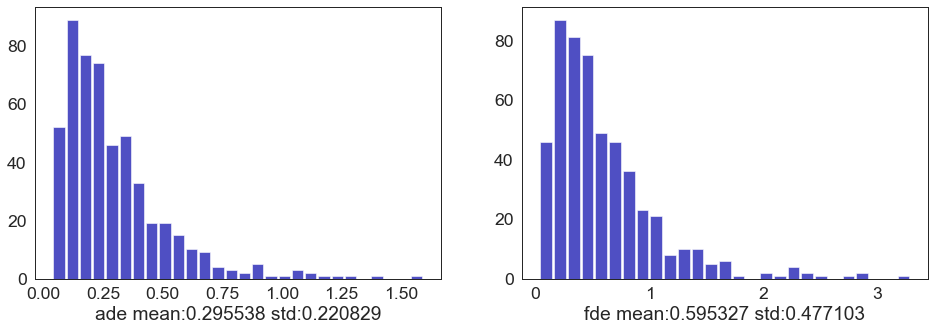

In [22]:
evaluator = DistanceErrorEvaluator(N_future=future_traj_length, N_history=history_traj_length)
result = evaluator.evaluate(predictor, trajlets_for_testing)
evaluator.hist()
res_state = evaluator.statistic()

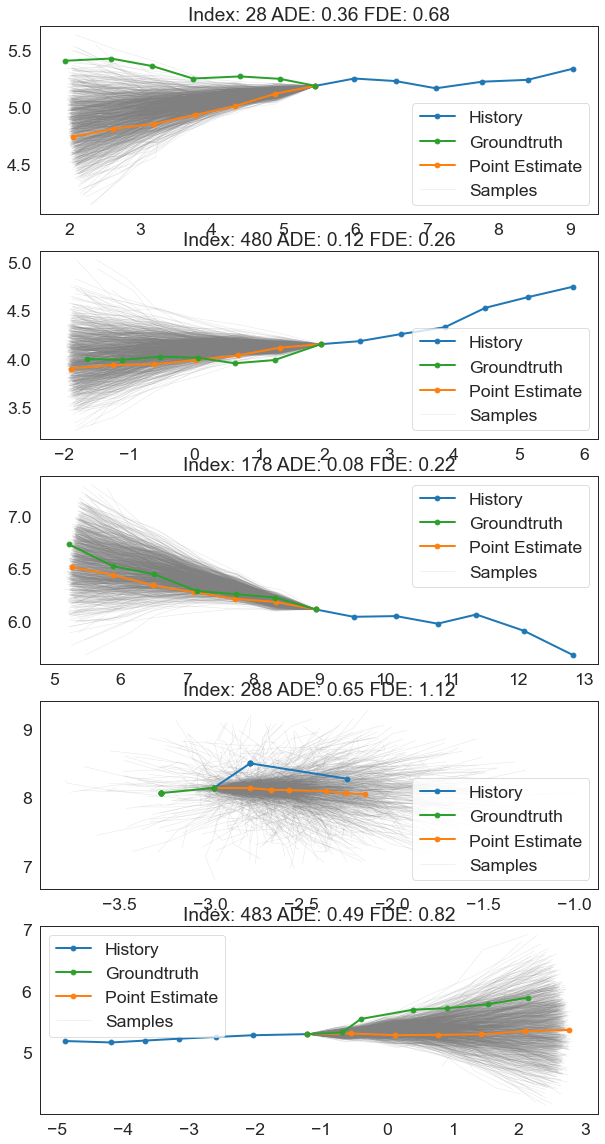

In [23]:
import matplotlib.pyplot as plt

viz = SamplingVisualizer(N_future=4, N_history=history_traj_length, sample_size=1000)
fig, axs = plt.subplots(5, 1, figsize=(10, 20))

for ax in axs:
    idx = np.random.randint(0, trajlets_for_testing.shape[0])
    traj = trajlets_for_testing[idx, :, :]
    viz.visualize_to_axis(ax, predictor, traj)
    ax.set_title(f"Index: {idx} ADE: {result['ade'][idx]:.2f} FDE: {result['fde'][idx]:.2f}")
#     ax.set_aspect(1)